# Look at hash values to see if every transcript and operons/regulons contains at least one hash

FracMinHash sketching selects a subset of k-mers in sequencing data (genome, transcriptome, FASTQ files, etc). This representative subset can be used to make rapid comparisons between potentially large sets of sketches. The fraction of k-mers selected in a FracMinHash sketch depends on the scaled value. In this repository, we used a scaled value of 1000, meaning approximately 1/1000th of the distinct k-mers were retained in each sketch. The idea behind using this number is that it would approximately correspond to the average gene length in most bacteria (1000bp), with the hope that we would get at least one k-mer per gene in a genome. This notebook determines the number of hashes that each "transcript" (genes in a cDNA file) or operon contains, and the number of transcripts or operons that end up without a hash in the FracMinHash sketch.

In [1]:
setwd("..")

In [2]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

In [4]:
library(readr)
library(dplyr)
library(tibble)
library(tidyr)
library(purrr)
library(ggplot2)
library(ggpubr)

## Investigate how many cDNAs (transcripts) are represented in the sketch

In [6]:
pa14_hash_map <- read_csv("outputs/txomes_sourmash_sketch_singleton/pa14.csv", show_col_types = F)

In [7]:
head(pa14_hash_map)

minhash,abund,name
<dbl>,<dbl>,<chr>
5477674659550458,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit"
8655017080968988,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit"
13224287242744290,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit"
14457255237130468,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit"
0,NA,ABJ14957 cdna chromosome:ASM1462v1:Chromosome:483:2027:1 gene:PA14_00010 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:dnaA description:chromosomal replication initiator protein DnaA
0,NA,"ABJ14958 cdna chromosome:ASM1462v1:Chromosome:2056:3159:1 gene:PA14_00020 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:dnaN description:DNA polymerase III, beta chain"


In [9]:
# how many transcripts did not have a hash?
table(is.na(pa14_hash_map$abund))


FALSE  TRUE 
 5611  2617 

In [10]:
# how many unique sequences were there in the pa14 "transcriptome" (cDNA file)?
length(unique(pa14_hash_map$name))

[1] 5892

In [11]:
# how many of these sequences ended up with a hash representing it?
pa14_hash_map %>%
  select(abund, name) %>%
  distinct() %>%
  group_by(abund) %>%
  tally()

abund,n
<dbl>,<int>
1,3275
2,2
NA,2617


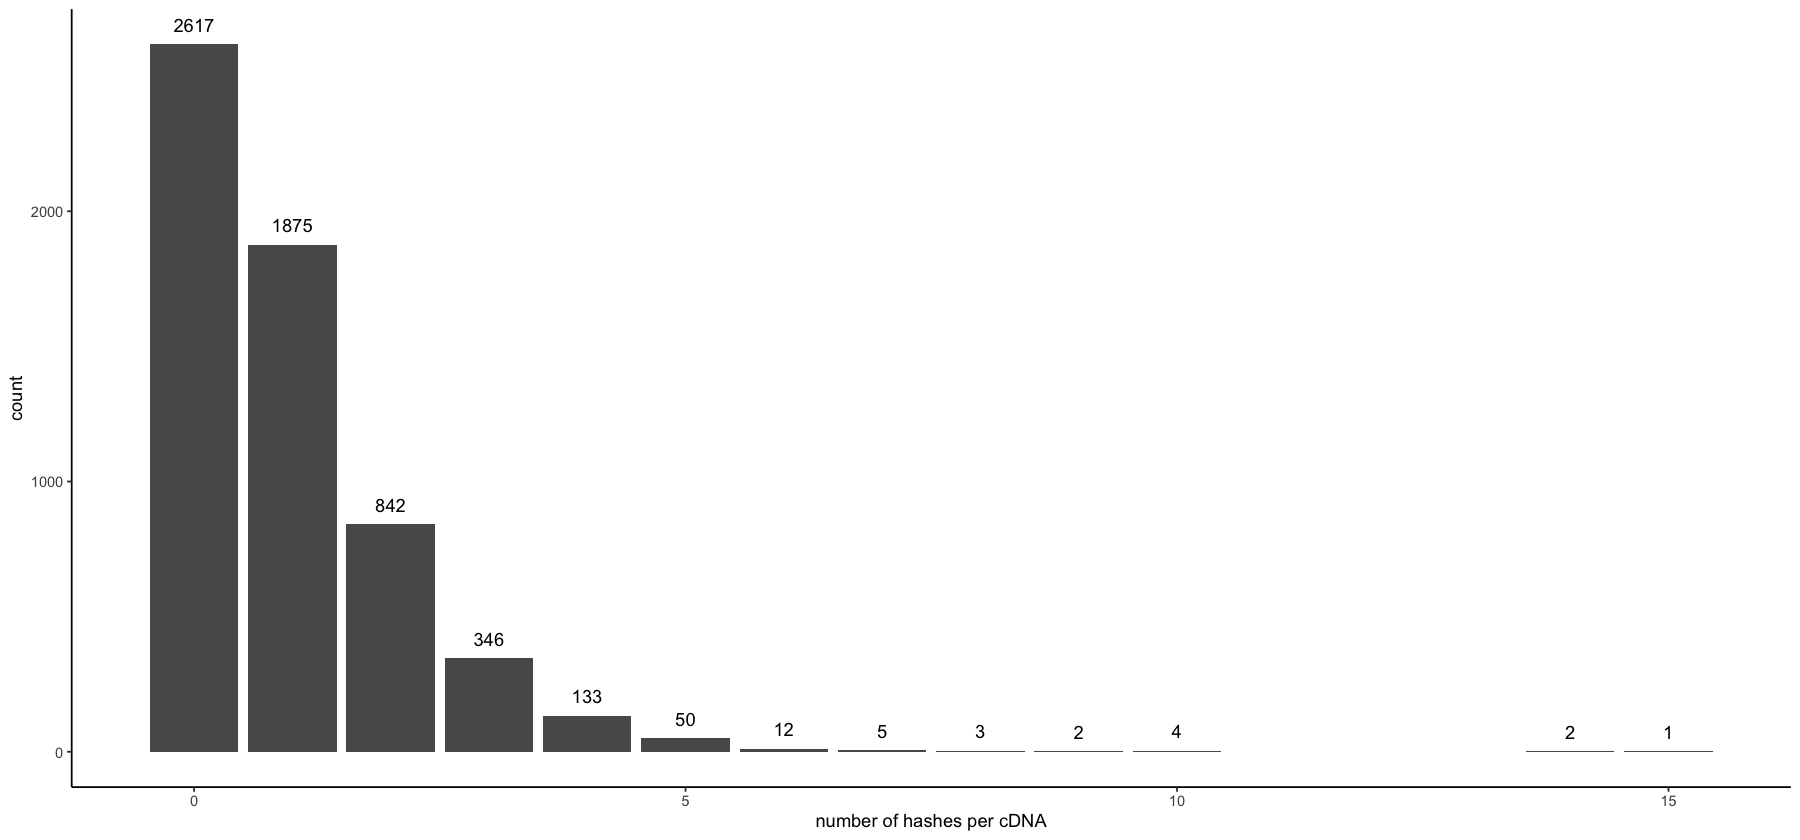

In [12]:
# how many hashes did each transcript end up having?
pa14_hash_map_tally <- pa14_hash_map %>%
  filter(!is.na(abund)) %>%
  group_by(name) %>%
  tally()

pa14_hash_map_tally_tmp <- pa14_hash_map %>%
  filter(is.na(abund)) %>%
  group_by(name) %>%
  tally() %>%
  mutate(n = 0) 

pa14_hash_map_tally <- bind_rows(pa14_hash_map_tally, pa14_hash_map_tally_tmp)

ggplot(pa14_hash_map_tally, aes(x = n)) +
  geom_bar() +
  theme_classic() +
  geom_text(stat='count', aes(label=..count..), vjust=-1) +
  labs(x = "number of hashes per cDNA")

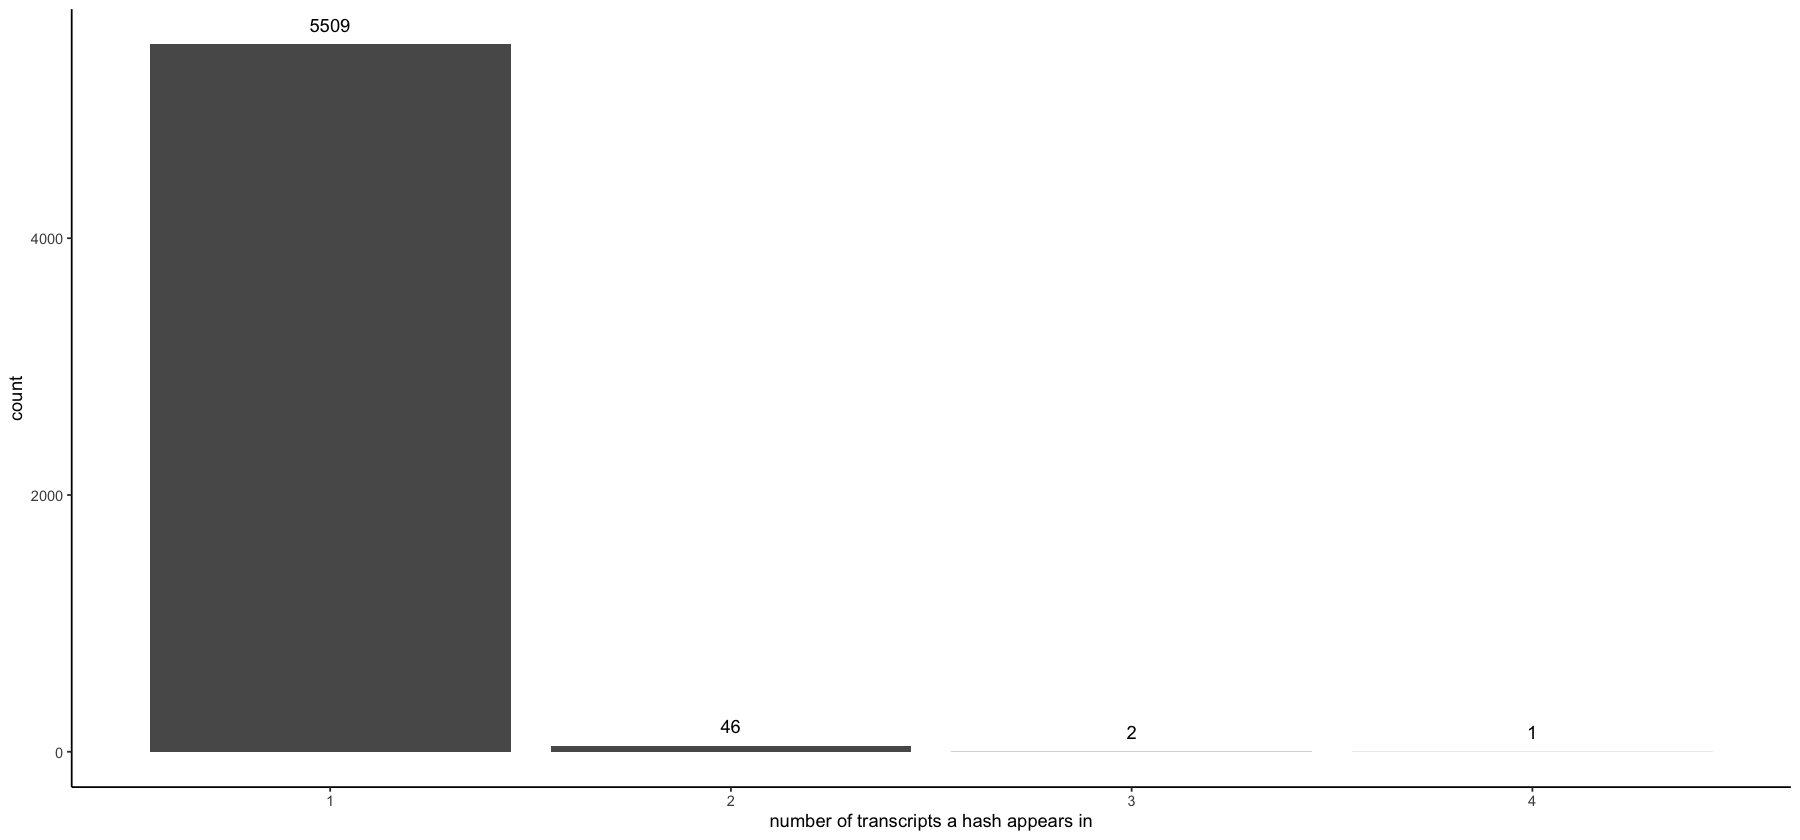

In [13]:
# how many "collisions" are there -- e.g. how many times does the same hash appear in different transcripts
pa14_hash_map_minhash_tally <- pa14_hash_map %>%
  filter(!is.na(abund)) %>%
  group_by(minhash) %>%
  tally() %>%
  arrange(desc(n))

ggplot(pa14_hash_map_minhash_tally, aes(x = n))  +
  geom_bar() +
  theme_classic() +
  geom_text(stat='count', aes(label=..count..), vjust=-1) +
  labs(x = "number of transcripts a hash appears in")

## Investigate how many operons are represented in the sketch

look at some of the same metrics, but do it for operons instead of for genes

In [14]:
# read in operon annotations
pa14_operons <- read_csv("https://raw.githubusercontent.com/greenelab/core-accessory-interactome/master/data/metadata/PA14-operons-2021-07-19.csv", show_col_types = F)

In [21]:
# how many operons are there?
length(unique(pa14_operons$`operon-id`))

[1] 1243

In [22]:
# read in transcript:gene map to join operon data to hash data
pa14_transcript_to_gene <- read_csv("https://osf.io/ema5c/download", skip = 1, col_names = c("tmp", "transcript_name", "locus_tag"), show_col_types = F) %>%
  select(-tmp)

In [16]:
head(pa14_operons)

operon-id,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00010,483,2027,1,dnaA,DOOR,18988623
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00020,2056,3159,1,dnaN,DOOR,18988623
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00030,3169,4278,1,recF,DOOR,18988623
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00050,4275,6695,1,gyrB,DOOR,18988623
operon-8959,PA14_00070-PA14_00060,PA14_00060,7018,7791,-1,NA,DOOR,18988623
operon-8959,PA14_00070-PA14_00060,PA14_00070,7803,8339,-1,NA,DOOR,18988623


In [17]:
pa14_hash_map <- pa14_hash_map %>%
  mutate(transcript_name = gsub(" .*", "", name)) %>%
  left_join(pa14_transcript_to_gene, by = "transcript_name") %>%
  left_join(pa14_operons, by = "locus_tag")

In [18]:
head(pa14_hash_map)
length(unique(pa14_hash_map$`operon-id`))

minhash,abund,name,transcript_name,locus_tag,operon-id,operon_name,start,end,strand,gene_name,source_database,pmid
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
5477674659550458,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit",ABJ15654,PA14_63605,operon-10022,fdnG-fdnH-fdnI,5669268,5672348,-1,fdnG,DOOR,18988623
8655017080968988,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit",ABJ15654,PA14_63605,operon-10022,fdnG-fdnH-fdnI,5669268,5672348,-1,fdnG,DOOR,18988623
13224287242744290,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit",ABJ15654,PA14_63605,operon-10022,fdnG-fdnH-fdnI,5669268,5672348,-1,fdnG,DOOR,18988623
14457255237130468,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit",ABJ15654,PA14_63605,operon-10022,fdnG-fdnH-fdnI,5669268,5672348,-1,fdnG,DOOR,18988623
0,NA,ABJ14957 cdna chromosome:ASM1462v1:Chromosome:483:2027:1 gene:PA14_00010 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:dnaA description:chromosomal replication initiator protein DnaA,ABJ14957,PA14_00010,operon-8958,dnaA-dnaN-recF-gyrB,483,2027,1,dnaA,DOOR,18988623
0,NA,"ABJ14958 cdna chromosome:ASM1462v1:Chromosome:2056:3159:1 gene:PA14_00020 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:dnaN description:DNA polymerase III, beta chain",ABJ14958,PA14_00020,operon-8958,dnaA-dnaN-recF-gyrB,2056,3159,1,dnaN,DOOR,18988623


[1] 1232

In [19]:
# how many transcripts are in operons?
table(is.na(pa14_hash_map$`operon-id`))


FALSE  TRUE 
 5194  3034 

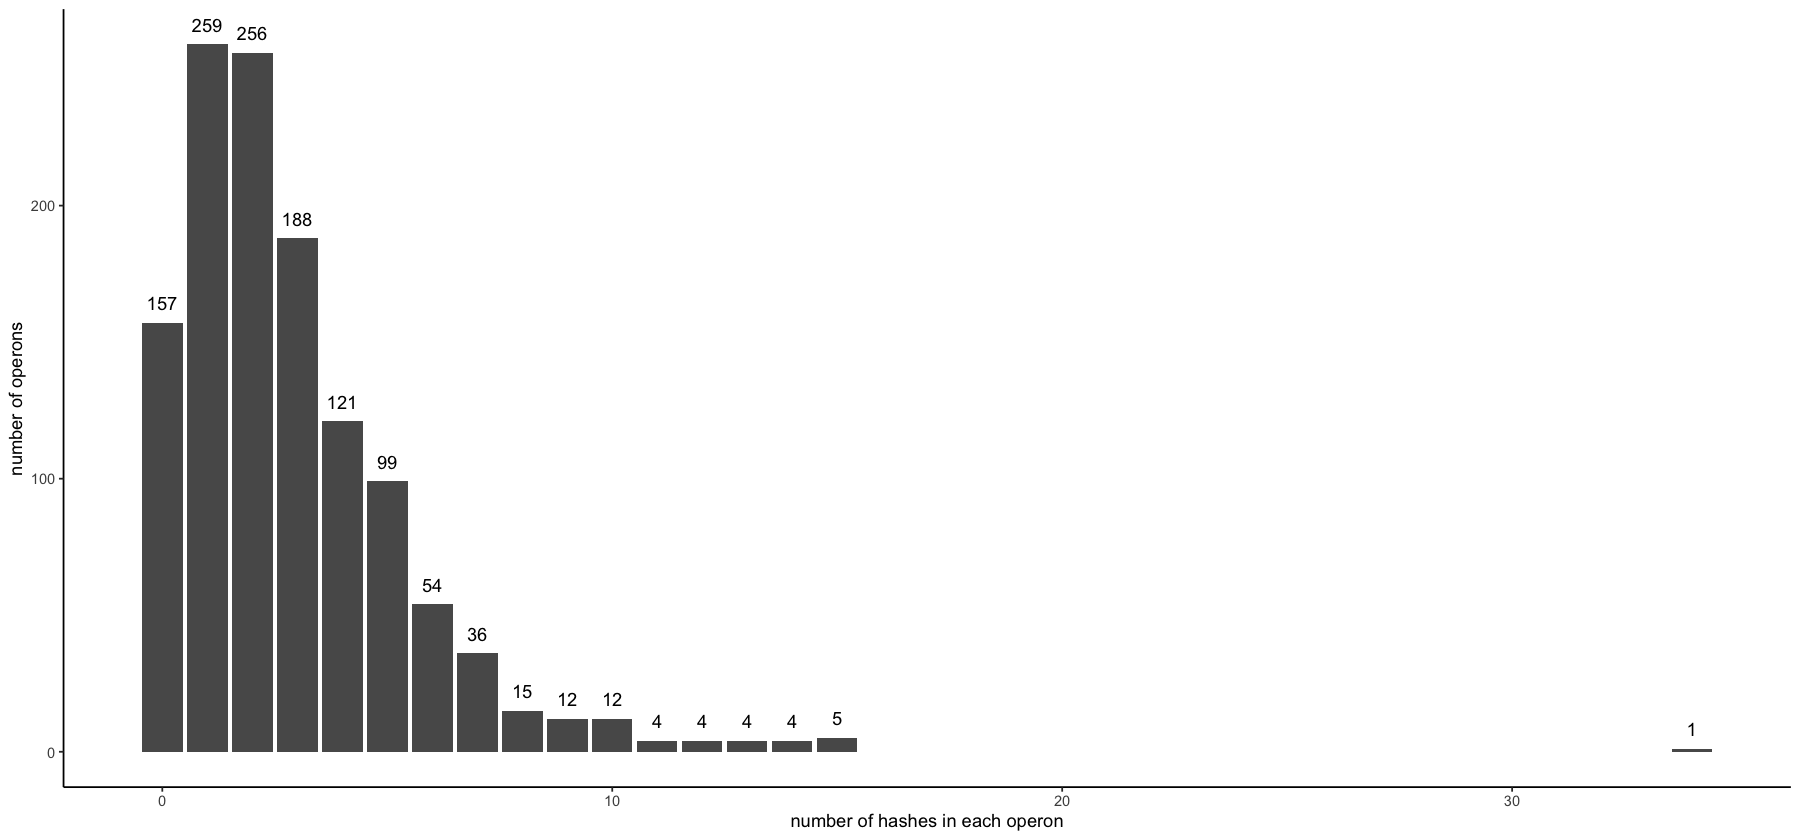

In [20]:
# does every operon have at least one hash?
pa14_hash_map_operon <- pa14_hash_map %>%
  filter(!is.na(`operon-id`))

hashes_in_operon <- pa14_hash_map_operon %>%
  replace_na(list(abund = 0)) %>%
  group_by(`operon-id`) %>%
  mutate(hashes_in_operon = sum(abund)) %>%
  select(operon_id = `operon-id`, hashes_in_operon) %>%
  distinct()

ggplot(hashes_in_operon, aes(x = hashes_in_operon)) +
  geom_bar() +
  theme_classic() +
  geom_text(stat='count', aes(label=..count..), vjust=-1) +
  labs(x = "number of hashes in each operon", y = "number of operons")

In [20]:
pa14_hash_map_operon_small <- pa14_hash_map_operon %>%
  select(minhash, operon_id = `operon-id`) %>%
  distinct()

## Conclusions

Using a scaled value of 1000, about 44% of genes in the pseudomonas "transcriptome" (cDNA) don't have a hash, and so are not represented in the FracMinHash sketch. Conversely, about 12.6% of operons don't have a hash. 

Genes aren't super well covered, but operons are. Even still, we still miss some.